In [15]:
## Requirements
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data pre process

In [16]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 150

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [17]:
train_path = './Cooking_Dataset/train'
test_path = './Cooking_Dataset/test'
dev_path = './Cooking_Dataset/dev'

train_ingradients = []
train_recipes = []
test_ingradients = []
test_recipes = []
dev_ingradients = []
dev_recipes = []


def data_extract(data_path):
    ingradients = []
    recipes = []
    files =  os.listdir(data_path)
    for f in files:
        data = open(os.path.join(data_path, f))
        lines = data.readlines()
        is_recipe =  0
        recipe = ""
        for line in lines:
            if "ingredients:" in line:
                ingradients.append(line)
                is_recipe = 1
            elif 'END RECIPE' in line:
                is_recipe = 0
                recipes.append(recipe)
                recipe = ""
            elif is_recipe == 1:
                line = line.replace('\n','\t')
                recipe = recipe + line.replace('\t',' ')
           

    return ingradients, recipes

train_ingradients, train_recipes = data_extract(train_path)
test_ingradients, test_recipes = data_extract(test_path)
dev_ingradients, dev_recipes = data_extract(dev_path)


In [18]:
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [19]:
lang = input_lang = Lang("ing")

pairs = [[train_ingradients[i], train_recipes[i]] for i in range(len(train_ingradients))]
pairs_test = [[test_ingradients[i], test_recipes[i]] for i in range(len(test_ingradients))]
pairs_dev = [[dev_ingradients[i], dev_recipes[i]] for i in range(len(dev_ingradients))]


min_train_ing_len = min([len(pair[0]) for pair in pairs])
min_train_rec_len = min([len(pair[1]) for pair in pairs])

max_train_ing_len = max([len(pair[0]) for pair in pairs])
max_train_rec_len = max([len(pair[1]) for pair in pairs])

ave_train_ing_len = sum([len(pair[0]) for pair in pairs]) / len(pairs)
ave_train_rec_len = sum([len(pair[1]) for pair in pairs]) / len(pairs)

pairs = filterPairs(pairs)
pairs_test = filterPairs(pairs_test)
pairs_dev = filterPairs(pairs_dev)

for pair in pairs:
        lang.addSentence(pair[0])
        lang.addSentence(pair[1])

for pair in pairs_test:
        lang.addSentence(pair[0])
        lang.addSentence(pair[1])

for pair in pairs_dev:
        lang.addSentence(pair[0])
        lang.addSentence(pair[1])

In [20]:
print(len(train_ingradients))
print(min_train_ing_len, min_train_rec_len)
print(max_train_ing_len, max_train_rec_len)
print(ave_train_ing_len, ave_train_rec_len)
print(len(pairs))
print(lang.n_words)

143907
17 0
2460 4427
235.31318142967334 529.653950120564
113100
172249


In [21]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(lang, pair):
    input_tensor = tensorFromSentence(lang, pair[0])
    target_tensor = tensorFromSentence(lang, pair[1])
    return (input_tensor, target_tensor)

In [22]:
x = random.choice(pairs)
training_pairs = tensorsFromPair(lang, x)
print(training_pairs[0].size())
print(training_pairs[1].size())

torch.Size([55, 1])
torch.Size([110, 1])


# model without attetion define and train

In [23]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super(EncoderLSTM, self).__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, hidden, cell):      
        embedded = self.embedding(src).view(1, 1, -1)  
        embedded = self.dropout(embedded)      
        outputs, (hidden, cell) = self.rnn(embedded, (hidden, cell))      
        return outputs, hidden, cell

    def initHidden(self):
        return torch.zeros(1, 1, self.hid_dim, device=device),torch.zeros(1, 1, self.hid_dim, device=device)

In [24]:
class DecoderLSTM(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super(DecoderLSTM, self).__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim) 
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)  
        embedded = self.dropout(embedded)         
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        prediction = self.softmax(prediction)
        
        return prediction, hidden, cell
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hid_dim, device=device),torch.zeros(1, 1, self.hid_dim, device=device)
    

In [25]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden, encoder_cell = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hid_dim, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(
            input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(
                decoder_input, decoder_hidden, decoder_cell)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(
                decoder_input, decoder_hidden, decoder_cell)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break


    return loss

    #return 


In [26]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [27]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
    
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [28]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, batch_size = 10):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(lang, random.choice(pairs))
                      for i in range(n_iters)]
    dev_pairs = [tensorsFromPair(lang, pair) for pair in pairs_dev]
    criterion = nn.NLLLoss()
    
    loss = 0
    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        cur_loss = train(input_tensor, target_tensor, encoder,
                     decoder, criterion)
        loss += cur_loss


        print_loss_total += cur_loss.item() / target_tensor.size(0)
        plot_loss_total += cur_loss.item() / target_tensor.size(0)

        if iter % print_every == 0:
            dev_loss = 0
            with torch.no_grad():
                for dev_pair in dev_pairs:
                    input_tensor = dev_pair[0]
                    target_tensor = dev_pair[1]
                    dev_loss += train(input_tensor, target_tensor, encoder,
                        decoder, criterion) / target_tensor.size(0)
            dev_loss = dev_loss.item() / len(dev_pairs)

            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) train: %.4f dev: %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, dev_loss))

        if iter % plot_every == 0:
            dev_loss = 0
            with torch.no_grad():
                for dev_pair in dev_pairs:
                    input_tensor = dev_pair[0]
                    target_tensor = dev_pair[1]
                    dev_loss += train(input_tensor, target_tensor, encoder,
                        decoder, criterion) / target_tensor.size(0)
            dev_loss = dev_loss.item() / len(dev_pairs)
            
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append([plot_loss_avg, dev_loss])
            plot_loss_total = 0
            
        if iter % batch_size:
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            loss = 0

    # showPlot(plot_losses)
    return plot_losses


In [29]:
input_dim = lang.n_words
output_dim = lang.n_words
emb_dim = 64
hid_dim = 256
n_layers = 1
dropout = 0.1
encoder1 = EncoderLSTM(input_dim, emb_dim, hid_dim, n_layers, dropout).to(device)
decoder1 = DecoderLSTM(output_dim, emb_dim, hid_dim, n_layers, dropout).to(device)
batch_size = 10

In [62]:
# encoder1 = torch.load('encoder1.pt')
# decoder1 = torch.load('decoder1.pt')

In [30]:
train_process = trainIters(encoder1, decoder1, 15000, print_every=100, batch_size = batch_size)

1m 11s (- 177m 44s) (100 0%) train: 9.6214 dev: 7.4518


KeyboardInterrupt: 

In [72]:
torch.save(encoder1,'encoder1.pt')
torch.save(decoder1,'decoder1.pt')

f = open("train_process.txt", 'w+')
for p in train_process:
    f.write(str(p[0])+ ' ' + str(p[1]) + '\n')

In [21]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden, encoder_cell = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hid_dim, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei],
                                                     encoder_hidden, encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(
                decoder_input, decoder_hidden, decoder_cell)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [22]:
def evaluateRandomly(encoder, decoder, n=2):
    for i in range(n):
        pair = random.choice(pairs_test)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# model with attetion define and train

In [65]:
class AttnDecoderLSTM(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, max_length=MAX_LENGTH):
        super(AttnDecoderLSTM, self).__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.max_length = max_length

        self.embedding = nn.Embedding(output_dim, emb_dim) 
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first=True)
        self.attn = nn.Linear(self.hid_dim * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hid_dim * 2, self.hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, input, hidden, cell, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)  
        embedded = self.dropout(embedded)  

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        prediction = self.softmax(prediction)
        
        return prediction, hidden, cell, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hid_dim, device=device),torch.zeros(1, 1, self.hid_dim, device=device)
    

In [66]:
teacher_forcing_ratio = 1


def train_attn(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden, encoder_cell = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hid_dim, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(
            input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    return loss


In [67]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, batch_size = 10):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(lang, random.choice(pairs))
                      for i in range(n_iters)]
    
    dev_pairs = [tensorsFromPair(lang, pair) for pair in pairs_dev]
    
    criterion = nn.NLLLoss()
    loss = 0
    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        cur_loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, criterion)
        loss += cur_loss


        print_loss_total += cur_loss.item() / target_tensor.size(0)
        plot_loss_total += cur_loss.item() / target_tensor.size(0)

        if iter % print_every == 0:
            dev_loss = 0
            with torch.no_grad():
                for dev_pair in dev_pairs:
                    input_tensor = dev_pair[0]
                    target_tensor = dev_pair[1]
                    dev_loss += train_attn(input_tensor, target_tensor, encoder,
                        decoder, criterion) / target_tensor.size(0)
            dev_loss = dev_loss.item() / len(dev_pairs)

            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) train: %.4f dev: %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, dev_loss))

        if iter % plot_every == 0:
            dev_loss = 0
            with torch.no_grad():
                for dev_pair in dev_pairs:
                    input_tensor = dev_pair[0]
                    target_tensor = dev_pair[1]
                    dev_loss += train_attn(input_tensor, target_tensor, encoder,
                        decoder, criterion) / target_tensor.size(0)
            dev_loss = dev_loss.item() / len(dev_pairs)

            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append([plot_loss_avg, dev_loss])
            plot_loss_total = 0
            
        if iter % batch_size:
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            loss = 0

    # showPlot(plot_losses)
    return plot_losses

In [68]:
encoder = EncoderLSTM(input_dim, emb_dim, hid_dim, n_layers, dropout).to(device)
attn_decoder = AttnDecoderLSTM(output_dim, hid_dim, hid_dim, n_layers, dropout, MAX_LENGTH).to(device)

In [69]:
att_train_process = trainIters_attn(encoder, attn_decoder, 15000, print_every = 100)

1m 25s (- 213m 29s) (100 0%) train: 8.9125 dev: 7.7972
3m 32s (- 261m 31s) (200 1%) train: 6.7749 dev: 6.5390
5m 37s (- 275m 30s) (300 2%) train: 6.1857 dev: 5.7561
7m 43s (- 281m 58s) (400 2%) train: 5.6621 dev: 5.5736
9m 51s (- 286m 4s) (500 3%) train: 5.9334 dev: 5.6216
11m 56s (- 286m 35s) (600 4%) train: 5.3471 dev: 5.2093
14m 5s (- 287m 43s) (700 4%) train: 5.3117 dev: 5.1270
16m 12s (- 287m 47s) (800 5%) train: 5.0588 dev: 5.0043
18m 14s (- 285m 43s) (900 6%) train: 4.8448 dev: 4.9164
20m 11s (- 282m 35s) (1000 6%) train: 5.0260 dev: 5.1612
22m 8s (- 279m 53s) (1100 7%) train: 4.8724 dev: 4.7910
24m 11s (- 278m 9s) (1200 8%) train: 4.7923 dev: 4.7703
26m 10s (- 275m 54s) (1300 8%) train: 4.7942 dev: 4.6463
28m 13s (- 274m 6s) (1400 9%) train: 4.6441 dev: 4.6719
30m 13s (- 271m 57s) (1500 10%) train: 4.7660 dev: 4.6420
32m 10s (- 269m 26s) (1600 10%) train: 4.6134 dev: 4.5838
34m 9s (- 267m 11s) (1700 11%) train: 4.6917 dev: 4.5280
36m 9s (- 265m 10s) (1800 12%) train: 4.5222 dev

In [26]:
# encoder = torch.load('encoder2.pt')
# attn_decoder = torch.load('decoder2.pt')

In [74]:
torch.save(encoder,'encoder2.pt')
torch.save(attn_decoder,'decoder2.pt')

f = open("att_train_process.txt", 'w+')
for p in att_train_process:
    f.write(str(p[0])+ ' ' + str(p[1]) + '\n')

In [27]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden, encoder_cell = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hid_dim, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei],
                                                     encoder_hidden, encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [28]:
def evaluateRandomly_attn(encoder, decoder, n=2):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [76]:
evaluateRandomly_attn(encoder, attn_decoder)

> ingredients: 1    four-pound chicken	2 c  carrots, diced	1 c  celery, diced	1/4 c  cooking fat	1/2 c  minced onion	1 c  milk	1 c  hot water	salt and pepper	1    green pepper, chopped	flour

= cut chicken pieces . dredge with flour . brown in hot cooking fat . season with salt and pepper . place chicken in casserole . add water . cover . cook slowly until chicken is tender . add vegetables which have been browned in the cooking fat . cover . cook slowly until vegetables are tender . add water if necessary . remove chicken . combine milk and 2 tablespoons flour . mix until smooth . combine with vegetables and chicken broth . cook slowly , stirring constantly until smooth . serve with chicken . 8 servings . mrs. m. westrum , scarville , ia . 
< in a large bowl , combine all ingredients except cheese . in a bowl , combine flour , baking powder and salt . add flour and mix well . pour into greased muffin tins . bake at 350 degrees for 20 minutes .  <EOS>

> ingredients: 1 pk sugar-free ge

# loss plot

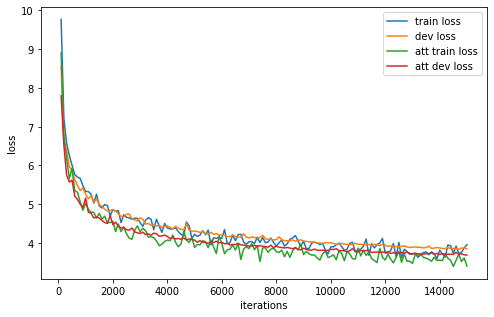

In [75]:
att_train_process = np.array(att_train_process)
train_process = np.array(train_process)
plt.figure(figsize=(8, 5))

x = [100 * (1 + i) for i in range(len(att_train_process))]
plt.xlabel("iterations")
plt.ylabel("loss")
plt.plot(x, train_process[:,0], label = 'train loss')
plt.plot(x, train_process[:,1], label = 'dev loss')
plt.plot(x, att_train_process[:,0], label = 'att train loss')
plt.plot(x, att_train_process[:,1], label = 'att dev loss')
plt.legend()
plt.show()

In [34]:
import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

# Quantitative Evaluation

In [97]:
def Quantitative_Evaluation(encoder, decoder, atten):
    bleu_score = 0
    for x, y in pairs_test:
        if atten:
            y_, a = evaluate_attn(encoder, decoder, x)
        else:
            y_ = evaluate(encoder, decoder, x)
        y = y.split(' ')
        bleu_score += nltk.translate.bleu_score.sentence_bleu(y_, y, smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)

    merteor_score  = 0
    for x, y in pairs_test:
        if atten:
            y_, a = evaluate_attn(encoder, decoder, x)
        else:
            y_ = evaluate(encoder, decoder, x)
        y = y.split(' ')
        merteor_score  += nltk.translate.meteor_score.single_meteor_score(y_, y)
    
    avg_given  = 0
    avg_extra  = 0
    for x, y in pairs_test:
        if atten:
            y_, a = evaluate_attn(encoder, decoder, x)
        else:
            y_ = evaluate(encoder, decoder, x)
        y = y.split(' ')
        y = set(y)
        y_ = set(y_)
        avg_given += len(y_ & y) / len(y_)
        avg_extra += len(y_ - y)
        
    print(avg_given /len(pairs_test))
    print(avg_extra /len(pairs_test))
    print(merteor_score /len(pairs_test))
    print(bleu_score/len(pairs_test))


In [98]:
Quantitative_Evaluation(encoder1, decoder1, False)

0.376930090143357
15.571428571428571
0.2481440169662675
0.004453949840304741


In [99]:
Quantitative_Evaluation(encoder, attn_decoder, True)

0.3755736051085988
18.159147869674186
0.23120818253495834
0.00461299991025577


# Qualitative Evaluation

In [134]:
sentence = "10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cup shredded swiss cheese, 2 tsp lemon juice, 2 cup cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated cheese, 1 can refrigerated biscuits"

output_words= evaluate(encoder1, decoder1, sentence)
output_sentence = ' '.join(output_words)
print(output_sentence)


in a large bowl , combine the remaining ingredients . mix well . add the remaining ingredients . cover and simmer for 30 minutes . remove from heat . add the rice and stir . add the rice and cook until the rice is tender . add the rice and stir . cover and simmer for 5 minutes . remove from heat . stir in the remaining ingredients . cover and simmer for 30 minutes . remove the bay leaf and serve .  <EOS>


In [143]:
sentence = "ingredients: 2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract"

output_words= evaluate(encoder1, decoder1, sentence)
output_sentence = ' '.join(output_words)
print(output_sentence)

in a large bowl , combine the sugar , sugar , cinnamon , cinnamon , nutmeg , and nutmeg . mix well . add the flour , baking powder and salt . stir in the flour , baking powder and salt . stir in the flour . bring to a boil . remove from heat and stir in the nuts . pour over the cake . bake in a preheated oven for 30 minutes .  <EOS>


In [167]:
sentence = "10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cup shredded swiss cheese, 2 tsp lemon juice, 2 cup cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated cheese, 1 can refrigerated biscuits"

output_words, output_attention = evaluate_attn(encoder1, attn_decoder, sentence)
output_sentence = ' '.join(output_words)
print(output_sentence)

in a large bowl , combine all ingredients except the oil . add the flour and mix well . add the flour and mix well . add the flour and mix well . add the flour and mix well . add the flour and mix well . add the milk and mix well . add the flour and mix well . add the flour and mix well . add the flour and mix well . add the flour and mix well . add the flour and mix well . add the egg yolks , one at a time , beating well after each addition . pour into a greased 9 x 13 x 9 x 13 pan . bake at 350 degrees for 20 minutes .  <EOS>


In [151]:
sentence = " 2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract"

output_words, output_attention = evaluate_attn(encoder, attn_decoder, sentence)
output_sentence = ' '.join(output_words)
print(output_sentence)


in a large bowl , combine all ingredients except the oil in a bowl . add the oil and mix well . add the water and stir . add the water and let stand for 5 minutes . add the water and let stand for 10 minutes . add the water and let stand for 5 minutes . add the water and let stand for 5 minutes . add the water and let stand for 5 minutes . add the water and let stand for 5 minutes . add the water and let stand for 10 minutes . add the remaining ingredients and mix well . pour into a serving dish and serve hot .  <EOS>
